# Proporciones altas de fondos en test - usando HOG

## Imports

In [1]:
# Encadenar iterables
from itertools import chain

# Proporciona una barra de progreso rápida
from tqdm import tqdm

# Interfaz para hacer gráficos y visualizaciones
import matplotlib.pyplot as plt

# Computación científica
import numpy as np

# Manipulación de datos
import pandas as pd

# Extraer parches (pequeños subconjuntos de imágenes) de imágenes
from sklearn.feature_extraction.image import PatchExtractor

# data: conjunto de datos de muestra y funciones de carga
# color: convertir imágenes entre espacios de color
# feature: funciones para identificar y extraer características de imágenes
from skimage import data, color, feature

# Cambiar el tamaño de una imagen
from skimage.transform import resize, rescale

# Descarga y carga en memoria un conjunto de datos de imágenes de caras de personas famosas
from sklearn.datasets import fetch_lfw_people

# Crear y verificar existencia de directorios.
import os

# Guardar imagenes
from PIL import Image

# Modelos
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Para guardar y cargar modelos
from joblib import dump, load

# Train test split
from sklearn.model_selection import train_test_split

# Matriz de confusión
from sklearn.metrics import confusion_matrix

# La curva ROC
from sklearn.metrics import roc_curve

# Classification report
from sklearn.metrics import classification_report

# Métricas varias
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

## Funciones auxiliares

In [2]:
# Función para extraer porciones de una imagen
def extract_patches(img, N, scale=1.0, patch_size=(62,47), random_state=0):
    # Calcula el tamaño del parche extraído basado en el factor de escala dado
    H = img.shape[0]
    W = img.shape[1]
    H_patch = min(H , int(scale * patch_size[0]))
    W_patch = min(W , int(scale * patch_size[1]))
    extracted_patch_size = (H_patch, W_patch)

    # Inicializa un objeto PatchExtractor con el tamaño de parche calculado,
    # el número máximo de parches, y una semilla de estado aleatorio
    extractor = PatchExtractor(patch_size=extracted_patch_size, max_patches=N, random_state=random_state)

    # Extrae parches de la imagen dada
    # img[np.newaxis] se utiliza la entrada de PatchExtractor es un conjunto de imágenes
    patches = extractor.transform(img[np.newaxis])

    # Si el factor de escala no es 1, redimensiona cada parche extraído
    # al tamaño del parche original
    if scale != 1:
        patches = np.array([resize(patch, patch_size) for patch in patches])

    # Devuelve la lista de parches extraídos (y posiblemente redimensionados)
    return patches

In [3]:
def non_max_suppression(indices, Ni, Nj, overlapThresh):
    # Si no hay rectángulos, regresar una lista vacía
    if len(indices) == 0:
        return []

    # Si las cajas son enteros, convertir a flotantes
    if indices.dtype.kind == "i":
        indices = indices.astype("float")

    # Inicializar la lista de índices seleccionados
    pick = []

    # Tomar las coordenadas de los cuadros
    x1 = np.array([indices[i,0] for i in range(indices.shape[0])])
    y1 = np.array([indices[i,1] for i in range(indices.shape[0])])
    x2 = np.array([indices[i,0]+Ni for i in range(indices.shape[0])])
    y2 = np.array([indices[i,1]+Nj for i in range(indices.shape[0])])

    # Calcula el área de los cuadros y ordena los cuadros
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # Mientras todavía hay índices en la lista de índices
    while len(idxs) > 0:
        # Toma el último índice de la lista y agrega el índice a la lista de seleccionados
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # Encontrar las coordenadas (x, y) más grandes para el inicio de la caja y las coordenadas (x, y) más pequeñas para el final de la caja
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # Calcula el ancho y alto de la caja
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # Calcula la proporción de superposición
        overlap = (w * h) / area[idxs[:last]]

        # Elimina todos los índices del índice de lista que tienen una proporción de superposición mayor que el umbral proporcionado
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))

    # Devuelve solo las cajas seleccionadas
    return indices[pick].astype("int")

In [4]:
# Define una función para realizar una ventana deslizante (sliding window) sobre una imagen.
def sliding_window(img,
                   patch_size=(62,47),  # Define el tamaño del parche (patch) basado en el primer parche positivo por defecto
                   istep=2,  # Paso de desplazamiento en la dirección i (verticalmente)
                   jstep=2,  # Paso de desplazamiento en la dirección j (horizontalmente)
                   scale=1.0):  # Factor de escala para ajustar el tamaño del parche

    # Calcula las dimensiones Ni y Nj del parche ajustadas por el factor de escala.
    Ni, Nj = (int(scale * s) for s in patch_size)

    # Itera a lo largo de la imagen en la dirección i
    for i in range(0, img.shape[0] - Ni, istep):
        # Itera a lo largo de la imagen en la dirección j
        for j in range(0, img.shape[1] - Ni, jstep):

            # Extrae el parche de la imagen usando las coordenadas actuales i, j.
            patch = img[i:i + Ni, j:j + Nj]

            # Si el factor de escala es diferente de 1, redimensiona el parche al tamaño original del parche.
            if scale != 1:
                patch = resize(patch, patch_size)

            # Usa yield para devolver las coordenadas actuales y el parche.
            # Esto convierte la función en un generador.
            yield (i, j), patch

In [5]:
# Función que devuelve el número de detecciones brutas y procesadas para diversas escalas
# Esta función asume conocidos model, size y los parámetros de las HOG
def detections_by_scale(test_image, test_scales, step, thresholds=[0.5]):
    raw_detections = []
    detections = []

    for scale in tqdm(test_scales):
        raw_detections_scale = []
        detections_scale = []

        # Ventana deslizante
        indices, patches = zip(*sliding_window(test_image, scale=scale, istep=step, jstep=step))

        # Calcula las características HOG para cada parche y las almacena en un array.
        patches_hog = np.array([feature.hog(patch,
                                            orientations=orientations,
                                            pixels_per_cell=pixels_per_cell,
                                            cells_per_block=cells_per_block) for patch in patches])
        # Predicción
        for thr in thresholds:
            labels = (model.predict_proba(patches_hog)[:,1]>=thr).astype(int)
            raw_detections_scale.append(labels.sum())
            Ni, Nj = (int(scale*s) for s in size)
            indices = np.array(indices)
            detecciones = indices[labels == 1]
            detecciones = non_max_suppression(np.array(detecciones),Ni,Nj, 0.3)
            detections_scale.append(len(detecciones))
        
        # Actualizamos las listas
        raw_detections.append(raw_detections_scale)
        detections.append(detections_scale)
        
    return np.array(raw_detections), np.array(detections)

In [6]:
# True Positive Rate
def tpr_scorer(clf, y, y_pred):
  cm = confusion_matrix(y, y_pred)
  tpr = cm[1,1]/(cm[1,1]+cm[1,0])
  return tpr

# False Positive Rate
def fpr_scorer(clf, y, y_pred):
  cm = confusion_matrix(y, y_pred)
  fpr = cm[0,1]/(cm[0,0]+cm[0,1])
  return fpr

# True Negative Rate
def tnr_scorer(clf, y, y_pred):
  cm = confusion_matrix(y, y_pred)
  tnr = cm[0,0]/(cm[0,0]+cm[0,1])
  return tnr

# True Negative Rate
def fnr_scorer(clf, y, y_pred):
  cm = confusion_matrix(y, y_pred,)
  fnr = cm[1,0]/(cm[1,0]+cm[1,1])
  return fnr


## Dataset de rostros (LFW)

In [7]:
# Cargamos el dataset
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

In [8]:
# Dividimos en train y test
positive_patches_train, positive_patches_test = train_test_split(
    positive_patches,
    test_size=0.1,
    random_state=42
)

In [9]:
print('Shape train: ',positive_patches_train.shape)
print('Shape test: ',positive_patches_test.shape)

Shape train:  (11909, 62, 47)
Shape test:  (1324, 62, 47)


## Dataset de fondos

41


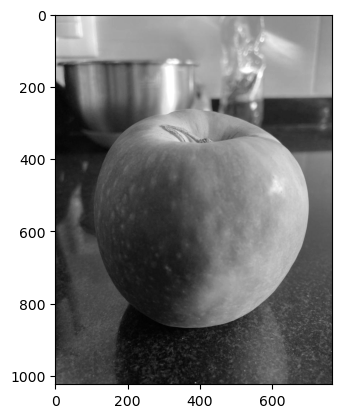

In [10]:
# Tomamos algunas imágenes de sklearn
imgs = ['camera',
        'text',
        'coins',
        'moon',
        'page',
        'clock',
        'immunohistochemistry',
        'chelsea',
        'coffee',
        'hubble_deep_field'
        ]

backgrounds = []
for name in imgs:
    img = getattr(data, name)()
    if len(img.shape) == 3 and img.shape[2] == 3:  # Chequeamos si la imagen es RGB
        img = color.rgb2gray(img)
    backgrounds.append(img)

# Imagenes caseras adicionales
for i in range(31):
    filename = './fondos/'+str(i)+'.jpg'
    img = plt.imread(filename)
    img = color.rgb2gray(img)
    backgrounds.append(img)

print(len(backgrounds))
fig, ax = plt.subplots()
ax.imshow(backgrounds[10], cmap='gray')
plt.show()


## Definimos el modelo, los datos y las HOG

In [11]:
# Modelo
model = RandomForestClassifier(n_estimators=1000, n_jobs=-1,verbose=2)

# Resolución de los rostros
resolution = 1

# Fondos
scales = [0.5,1,2,4,8]
proportion_train = 30
proportion_test = 100
num_patches_train = int((proportion_train * len(positive_patches_train))/(len(scales) * len(backgrounds)))
num_patches_test = int((proportion_test * len(positive_patches_test))/(len(scales) * len(backgrounds)))

# HOG
orientations = 3
pixels_per_cell = (12, 12)
cells_per_block = (3, 3)

# Nombre del experimento
model_name = str(model)
data_name = '_R_' + str(resolution)
data_name += '_S_' + str(scales)
data_name += '_PTrain_' + str(proportion_train)
data_name += '_PTest_' + str(proportion_test)
data_name += '_O_' + str(orientations)
data_name += '_C_' + str(pixels_per_cell)
data_name += '_B_' + str(cells_per_block)
experiment_name = model_name + data_name

# Creamos una carpeta para el experimento
directorio_actual = os.getcwd()
directorio_experimento = os.path.join(directorio_actual, r'experimentos' , experiment_name)
if not os.path.exists(directorio_experimento):
   os.makedirs(directorio_experimento)


print(experiment_name)

RandomForestClassifier(n_estimators=1000, n_jobs=-1, verbose=2)_R_1_S_[0.5, 1, 2, 4, 8]_PTrain_30_PTest_100_O_3_C_(12, 12)_B_(3, 3)


In [12]:
# Armamos la matriz de features y el vector de etiquetas

if os.path.isfile(r'./preprocesados/X_train' + data_name + r'.npz'):
    X_train = np.load(r'./preprocesados/X_train' + data_name + r'.npz')['arr_0']
    y_train = np.load(r'./preprocesados/y_train' + data_name + r'.npz')['arr_0']
    X_test = np.load(r'./preprocesados/X_test' + data_name + r'.npz')['arr_0']
    y_test = np.load(r'./preprocesados/y_test' + data_name + r'.npz')['arr_0']
else:
    # Train
    positive_patches_train = np.array(
        [rescale(positive_patches_train[i], resolution)
        for i in tqdm(range(len(positive_patches_train)))]
        )
    negative_patches_train = np.vstack(
        [extract_patches(im, num_patches_train, scale, random_state=42)
        for im in tqdm(backgrounds, desc='Procesando imágenes train')
        for scale in scales]
        )
    
    X_train = np.array(
        [feature.hog(image=im,
                    orientations=orientations,
                    pixels_per_cell=pixels_per_cell,
                    cells_per_block=cells_per_block)
        for im in tqdm(chain(positive_patches_train, negative_patches_train))]
        )
    np.savez_compressed(r'./preprocesados/X_train' + data_name + r'.npz', X_train)

    y_train = np.zeros(X_train.shape[0])
    y_train[:positive_patches_train.shape[0]] = 1
    np.savez_compressed(r'./preprocesados/y_train' + data_name + r'.npz', y_train)
    
    #Test
    positive_patches_test = np.array(
        [rescale(positive_patches_test[i], resolution)
        for i in tqdm(range(len(positive_patches_test)))]
        )
    negative_patches_test = np.vstack(
        [extract_patches(im, num_patches_test, scale, random_state=0)
        for im in tqdm(backgrounds, desc='Procesando imágenes test')
        for scale in scales]
        )

    X_test = np.array(
        [feature.hog(image=im,
                    orientations=orientations,
                    pixels_per_cell=pixels_per_cell,
                    cells_per_block=cells_per_block)
        for im in tqdm(chain(positive_patches_test, negative_patches_test))]
        )
    np.savez_compressed(r'./preprocesados/X_test' + data_name + r'.npz', X_test)
 
    y_test = np.zeros(X_test.shape[0])
    y_test[:positive_patches_test.shape[0]] = 1
    np.savez_compressed(r'./preprocesados/y_test' + data_name + r'.npz', y_test)
size = positive_patches_train[0].shape

In [13]:
print('Shape X_train: ', X_train.shape)
print('Shape y_train: ', y_train.shape)
print('Shape X_test: ', X_test.shape)
print('Shape y_test: ', y_test.shape)

Shape X_train:  (341220, 81)
Shape y_train:  (341220,)
Shape X_test:  (126680, 81)
Shape y_test:  (126680,)


## Entrenamiento y evaluación del modelo

In [14]:
# Entrenamos el modelo
model.fit(X_train,y_train)
dump(model, directorio_experimento + r'/modelo.joblib')


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.


building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   52.5s


building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building tree 41 of 1000
building tree 42 of 1000
building tree 43 of 1000
building tree 44 of 1000
building tree 45 of 1000
building tree 46 of 1000
building tree 47 of 1000
building tree 48 of 1000
building tree 49 of 1000
building tree 50 of 1000
building tree 51 of 1000
building tree 52 of 1000
building tree 53 of 1000
building tree 54 of 1000
building tree 55 of 1000
building tree 56 of 1000
building tree 57 of 1000
building tree 58 of 1000
building tree 59 of 1000
building tree 60 of 1000
building tree 61 of 1000
building tree 62 of 1000
building tree 63 of 1000
building tree 64 of 1000
building tree 65 of 1000
building tree 66 of 1000
building tree 67 of 1000
building tree 68 of 1000
building tree 69 of 1000
building tree 70 of 1000
building tree 71 of 1000
building tree 72 of 1000
building tree 73 of 1000
building tree 74 of 1000
building tree 75 of 1000


[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed:  4.0min


building tree 157 of 1000
building tree 158 of 1000
building tree 159 of 1000
building tree 160 of 1000
building tree 161 of 1000
building tree 162 of 1000
building tree 163 of 1000
building tree 164 of 1000
building tree 165 of 1000
building tree 166 of 1000
building tree 167 of 1000
building tree 168 of 1000
building tree 169 of 1000
building tree 170 of 1000
building tree 171 of 1000
building tree 172 of 1000
building tree 173 of 1000
building tree 174 of 1000
building tree 175 of 1000
building tree 176 of 1000
building tree 177 of 1000
building tree 178 of 1000
building tree 179 of 1000
building tree 180 of 1000
building tree 181 of 1000
building tree 182 of 1000
building tree 183 of 1000
building tree 184 of 1000
building tree 185 of 1000
building tree 186 of 1000
building tree 187 of 1000
building tree 188 of 1000
building tree 189 of 1000
building tree 190 of 1000
building tree 191 of 1000
building tree 192 of 1000
building tree 193 of 1000
building tree 194 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 353 tasks      | elapsed:  9.0min


building tree 360 of 1000
building tree 361 of 1000
building tree 362 of 1000
building tree 363 of 1000
building tree 364 of 1000
building tree 365 of 1000
building tree 366 of 1000
building tree 367 of 1000
building tree 368 of 1000
building tree 369 of 1000
building tree 370 of 1000
building tree 371 of 1000
building tree 372 of 1000
building tree 373 of 1000
building tree 374 of 1000
building tree 375 of 1000
building tree 376 of 1000
building tree 377 of 1000
building tree 378 of 1000
building tree 379 of 1000
building tree 380 of 1000
building tree 381 of 1000
building tree 382 of 1000
building tree 383 of 1000
building tree 384 of 1000
building tree 385 of 1000
building tree 386 of 1000
building tree 387 of 1000
building tree 388 of 1000
building tree 389 of 1000
building tree 390 of 1000
building tree 391 of 1000
building tree 392 of 1000
building tree 393 of 1000
building tree 394 of 1000
building tree 395 of 1000
building tree 396 of 1000
building tree 397 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 636 tasks      | elapsed: 16.1min


building tree 643 of 1000
building tree 644 of 1000
building tree 645 of 1000
building tree 646 of 1000
building tree 647 of 1000
building tree 648 of 1000
building tree 649 of 1000
building tree 650 of 1000
building tree 651 of 1000
building tree 652 of 1000
building tree 653 of 1000
building tree 654 of 1000
building tree 655 of 1000
building tree 656 of 1000
building tree 657 of 1000
building tree 658 of 1000
building tree 659 of 1000
building tree 660 of 1000
building tree 661 of 1000
building tree 662 of 1000
building tree 663 of 1000
building tree 664 of 1000
building tree 665 of 1000
building tree 666 of 1000
building tree 667 of 1000
building tree 668 of 1000
building tree 669 of 1000
building tree 670 of 1000
building tree 671 of 1000
building tree 672 of 1000
building tree 673 of 1000
building tree 674 of 1000
building tree 675 of 1000
building tree 676 of 1000
building tree 677 of 1000
building tree 678 of 1000
building tree 679 of 1000
building tree 680 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 26.8min finished


['d:\\OneDrive - Facultad de ingeniería\\Escritorio\\Obligatorio\\experimentos\\RandomForestClassifier(n_estimators=1000, n_jobs=-1, verbose=2)_R_1_S_[0.5, 1, 2, 4, 8]_PTrain_30_PTest_100_O_3_C_(12, 12)_B_(3, 3)/modelo.joblib']

In [15]:
# Predicciones
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:    0.6s
[Parallel(n_jobs=6)]: Done 353 tasks      | elapsed:    1.5s
[Parallel(n_jobs=6)]: Done 636 tasks      | elapsed:    2.8s
[Parallel(n_jobs=6)]: Done 1000 out of 1000 | elapsed:    4.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=6)]: Done 353 tasks      | elapsed:    1.7s
[Parallel(n_jobs=6)]: Done 636 tasks      | elapsed:    3.4s
[Parallel(n_jobs=6)]: Done 1000 out of 1000 | elapsed:    4.9s finished


In [17]:
print(classification_report(y_test,y_pred, digits=4))

              precision    recall  f1-score   support

         0.0     0.9987    1.0000    0.9993    125356
         1.0     0.9957    0.8792    0.9338      1324

    accuracy                         0.9987    126680
   macro avg     0.9972    0.9396    0.9666    126680
weighted avg     0.9987    0.9987    0.9987    126680



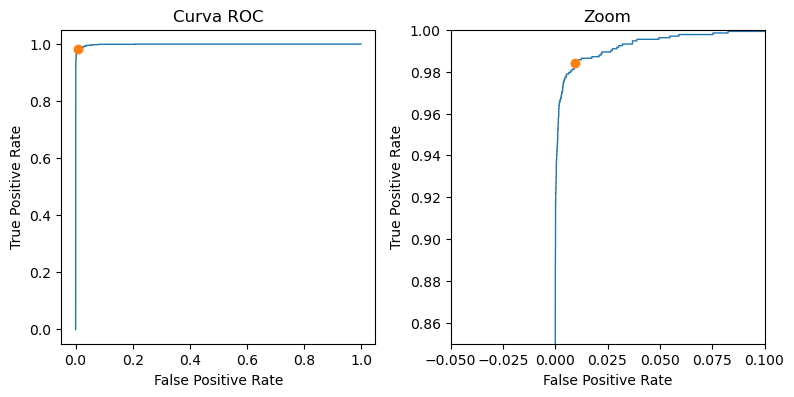

Umbral óptimo: 0.105
FPR: 0.0095, TPR: 0.9841


In [18]:
# Curva ROC y umbral óptimo
fig, ax = plt.subplots(1,2,figsize=(8, 8))

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
gmean = np.sqrt(tpr * (1 - fpr))
index = np.argmax(gmean)
thresholdOpt = round(thresholds[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)


ax[0].step(
    fpr,
    tpr,
    lw=1,
    alpha=1,
)

ax[0].plot(
    fprOpt,
    tprOpt,
    marker = 'o'
)

ax[0].set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Curva ROC",
)
ax[0].axis("square")

ax[1].set_aspect('equal')
ax[1].set_xlim([-0.05, 0.1])
ax[1].set_xbound(lower=-0.05, upper=0.1)
ax[1].set_ylim([0.85,1])
ax[1].set_ybound(lower=0.85, upper=1.0)

ax[1].step(
    fpr,
    tpr,
    lw=1,
    alpha=1,
)

ax[1].plot(
    fprOpt,
    tprOpt,
    marker = 'o'
)

ax[1].set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Zoom",
)

plt.tight_layout()
plt.savefig(directorio_experimento + r'\curva_roc.png')
plt.show()

print(f'Umbral óptimo: {thresholdOpt}')
print(f'FPR: {fprOpt}, TPR: {tprOpt}')

In [19]:
# Otra forma de calcular un umbral adecuado
indx = np.argmax(tpr>=0.85)
thresholdAde = thresholds[indx]
np.savez_compressed(directorio_experimento + r'/umbrales.npz', np.asarray([thresholdOpt, thresholdAde]))
print('Umbral adecuado: ', thresholdAde)


Umbral adecuado:  0.561


In [ ]:
# Métricas
y_pred = (y_pred_proba>=thresholdAde).astype(int)
acc = accuracy_score(y_test, y_pred)
b_acc = balanced_accuracy_score(y_test, y_pred)
prec = precision_score(y_test,y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
tpr = tpr_scorer(model, y_test, y_pred)
fpr = fpr_scorer(model, y_test, y_pred)
tnr = tnr_scorer(model, y_test, y_pred)
fnr = fnr_scorer(model, y_test, y_pred)

# Guardamos en un dataframe
results = pd.Series(
    data={
        'ACCURACY': acc,
        'PRECISION': prec,
        'RECALL': rec,
        'F1': f1,
        'B_ACCURACY': b_acc,
        'AUC': auc,
        'TPR': tpr,
        'FPR': fpr,
        'TNR': tnr,
        'FNR': fnr
    }
)

results.to_csv(directorio_experimento + r'/metricas.csv')

print(results)

## Test en varias imagenes


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 353 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 636 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done 1000 out of 1000 | elapsed:    0.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 353 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 636 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:    0.0s
[Paral

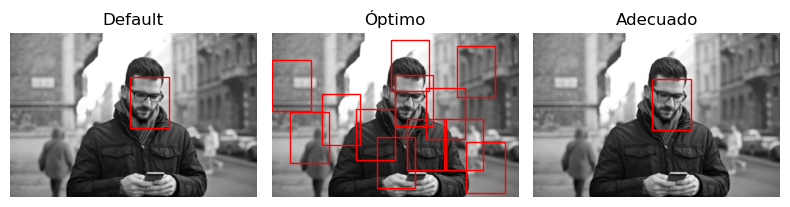

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 353 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done 636 tasks      | elapsed:    0.5s
[Parallel(n_jobs=6)]: Done 1000 out of 1000 | elapsed:    0.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 353 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done 636 tasks      | elapsed:    0.4s
[Parallel(n_jobs=6)]: Done 1000 out of 1000 | elapsed:    0.7s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:    0.0s
[Paral

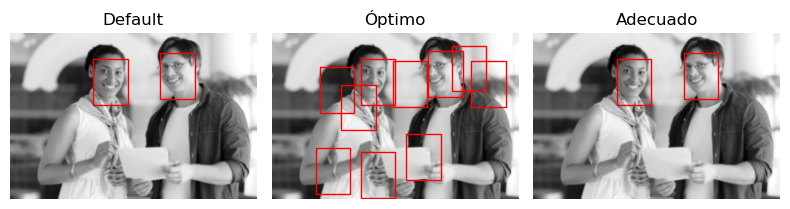

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 353 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 636 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done 1000 out of 1000 | elapsed:    0.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 353 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 636 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done 1000 out of 1000 | elapsed:    0.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:    0.0s
[Paral

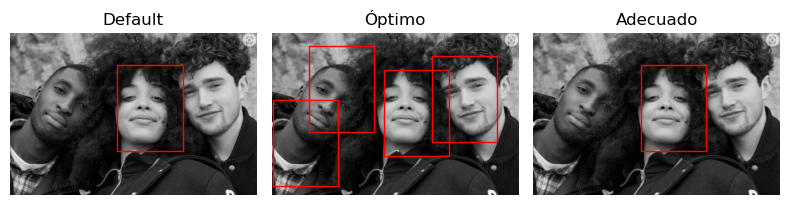

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done 353 tasks      | elapsed:    0.7s
[Parallel(n_jobs=6)]: Done 636 tasks      | elapsed:    1.4s
[Parallel(n_jobs=6)]: Done 1000 out of 1000 | elapsed:    2.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done 353 tasks      | elapsed:    0.8s
[Parallel(n_jobs=6)]: Done 636 tasks      | elapsed:    1.4s
[Parallel(n_jobs=6)]: Done 1000 out of 1000 | elapsed:    2.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:    0.2s
[Paral

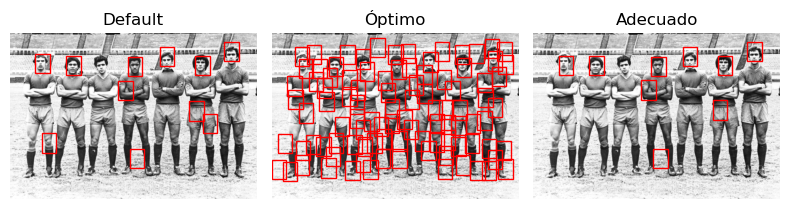

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 353 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 636 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 353 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 636 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:    0.0s
[Paral

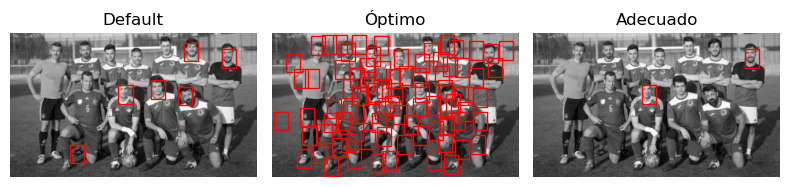

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 353 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done 636 tasks      | elapsed:    0.5s
[Parallel(n_jobs=6)]: Done 1000 out of 1000 | elapsed:    0.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 353 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done 636 tasks      | elapsed:    0.5s
[Parallel(n_jobs=6)]: Done 1000 out of 1000 | elapsed:    0.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:    0.0s
[Paral

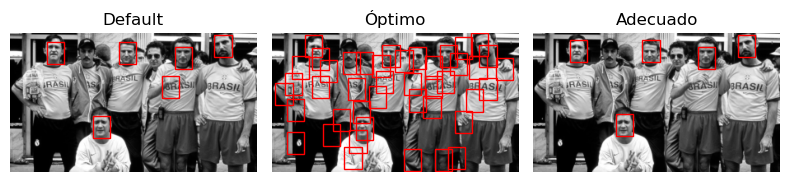

In [20]:
image_paths = [{"nombre":r'1_Rostro', "rescale":0.25, "true_scale": 1.2}, {"nombre":r'2_Rostros', "rescale":0.25, "true_scale": 0.75},{"nombre":r'3_Rostros', "rescale":0.75, "true_scale": 3.75}, {"nombre":r'Central', "rescale":0.5, "true_scale": 0.65}, {"nombre":r'equipo', "rescale":0.5, "true_scale": 0.4}, {"nombre":r'futbol7', "rescale":0.3, "true_scale": 0.45}]
    
if not os.path.exists(directorio_experimento + r'/tests'):
    os.makedirs(directorio_experimento + r'/tests')

for image_dict in image_paths:
    image = plt.imread(directorio_actual + r'/rostros/' + image_dict["nombre"] + r'.jpg')
    image = color.rgb2gray(image)
    image = rescale(image,image_dict["rescale"])
    true_scale = image_dict["true_scale"]

    indices, patches = zip(*sliding_window(image, scale = true_scale))
    
    patches_hog = np.array([feature.hog(patch,
                            orientations=orientations,
                            pixels_per_cell=pixels_per_cell,
                            cells_per_block=cells_per_block) for patch in patches])
    
    
    Ni, Nj = (int(true_scale*s) for s in size)
    indices = np.array(indices)

    # Umbral default
    labels_default = model.predict(patches_hog).astype(int)
    # Umbral óptimo
    labels_optimo = (model.predict_proba(patches_hog)[:,1]>=thresholdOpt).astype(int)
    # Umbral adecuado
    labels_adecuado = (model.predict_proba(patches_hog)[:,1]>=thresholdAde).astype(int)
            
    # Umbral default
    detecciones_default = indices[labels_default == 1]
    detecciones_default = non_max_suppression(np.array(detecciones_default),Ni,Nj, 0.3)

    # Umbral optimo
    detecciones_optimo = indices[labels_optimo == 1]
    detecciones_optimo = non_max_suppression(np.array(detecciones_optimo),Ni,Nj, 0.3)

    # Umbral adecuado
    detecciones_adecuado = indices[labels_adecuado == 1]
    detecciones_adecuado = non_max_suppression(np.array(detecciones_adecuado),Ni,Nj, 0.3)

    # Visualizamos las detecciones
    fig, ax = plt.subplots(1,3, figsize=(8,4))

    # Umbral default
    ax[0].imshow(image, cmap='gray')
    ax[0].axis('off')

    for i, j in detecciones_default:
        ax[0].add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',alpha=1, lw=1, facecolor='none'))

    ax[0].set_title('Default')

    # Umbral óptimo
    ax[1].imshow(image, cmap='gray')
    ax[1].axis('off')

    for i, j in detecciones_optimo:
        ax[1].add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',alpha=1, lw=1, facecolor='none'))

    ax[1].set_title('Óptimo')

    # Umbral adecuado
    ax[2].imshow(image, cmap='gray')
    ax[2].axis('off')

    for i, j in detecciones_adecuado:
        ax[2].add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',alpha=1, lw=1, facecolor='none'))

    ax[2].set_title('Adecuado')

    plt.tight_layout()
    plt.savefig(directorio_experimento + r'/tests/' + image_dict['nombre'])
    plt.show()

        


    

In [21]:
# Imagen de prueba
image = data.astronaut()
image = color.rgb2gray(image)
image = rescale(image, 0.5)
image = image[:160, 40:180]

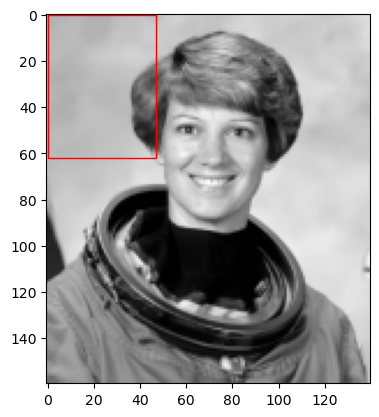

In [22]:
# Visualizamos la imagen
# Buscamos la escala de los rostros
fig, ax = plt.subplots()
ax.imshow(image, cmap='gray')

true_scale = 1
Ni, Nj = (int(true_scale * s) for s in size)

ax.add_patch(plt.Rectangle((0, 0), Nj, Ni, edgecolor='red', alpha=1, lw=1, facecolor='none'))
plt.show()

In [23]:
# Utiliza la función de ventana deslizante en una imagen de prueba.
# zip(*...) toma las tuplas generadas y las descompone en índices y parches.
indices, patches = zip(*sliding_window(image, scale=true_scale))

# Calcula las características HOG para cada parche y las almacena en un array.
patches_hog = np.array([feature.hog(patch,
                                    orientations=orientations,
                                    pixels_per_cell=pixels_per_cell,
                                    cells_per_block=cells_per_block) for patch in patches])

# Muestra la forma del array de características HOG.
patches_hog.shape

(1911, 81)

### Desempeño según umbrales

In [24]:
# Predicción

# Umbral default
labels_default = model.predict(patches_hog).astype(int)

# Umbral óptimo
labels_optimo = (model.predict_proba(patches_hog)[:,1]>=thresholdOpt).astype(int)

# Umbral adecuado
labels_adecuado = (model.predict_proba(patches_hog)[:,1]>=thresholdAde).astype(int)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 353 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 636 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 353 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 636 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:    0.0s
[Paral

In [25]:
Ni, Nj = (int(true_scale*s) for s in size)
indices = np.array(indices)

# Umbral default
detecciones_default = indices[labels_default == 1]
detecciones_default = non_max_suppression(np.array(detecciones_default),Ni,Nj, 0.3)

# Umbral optimo
detecciones_optimo = indices[labels_optimo == 1]
detecciones_optimo = non_max_suppression(np.array(detecciones_optimo),Ni,Nj, 0.3)

# Umbral adecuado
detecciones_adecuado = indices[labels_adecuado == 1]
detecciones_adecuado = non_max_suppression(np.array(detecciones_adecuado),Ni,Nj, 0.3)

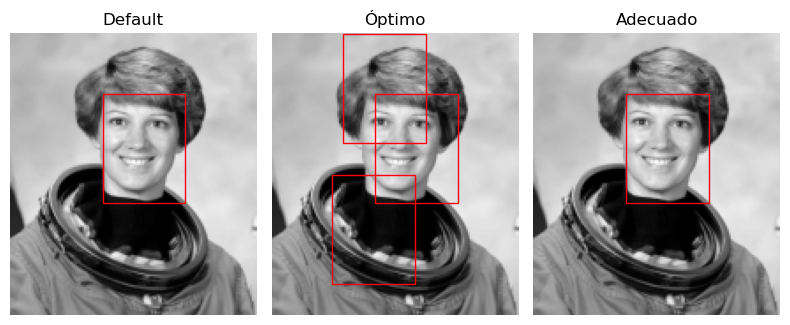

In [26]:
# Visualizamos las detecciones
fig, ax = plt.subplots(1,3, figsize=(8,4))

# Umbral default
ax[0].imshow(image, cmap='gray')
ax[0].axis('off')

for i, j in detecciones_default:
    ax[0].add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',alpha=1, lw=1, facecolor='none'))

ax[0].set_title('Default')

# Umbral óptimo
ax[1].imshow(image, cmap='gray')
ax[1].axis('off')

for i, j in detecciones_optimo:
    ax[1].add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',alpha=1, lw=1, facecolor='none'))

ax[1].set_title('Óptimo')

# Umbral adecuado
ax[2].imshow(image, cmap='gray')
ax[2].axis('off')

for i, j in detecciones_adecuado:
    ax[2].add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',alpha=1, lw=1, facecolor='none'))

ax[2].set_title('Adecuado')

plt.tight_layout()
plt.savefig(directorio_experimento + r'\tests\astronauta.png')
plt.show()

In [27]:
image_paths = [r'1_Rostro.jpg', r'2_Rostros.jpg', r'3_Rostros.jpg', r'Central.jpg', r'equipo.jpg', r'futbol7.jpg']



### Desempeño en varias escalas según umbral

In [28]:
# Escalas a testear
test_scales = np.linspace(0.125, 2, 50)

In [29]:
raw_detections, detections = detections_by_scale(
    image,
    test_scales,
    step=2,
    thresholds=[0.5, thresholdOpt, thresholdAde]
    )

  0%|          | 0/50 [00:00<?, ?it/s][Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 353 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 636 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 353 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 636 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 15

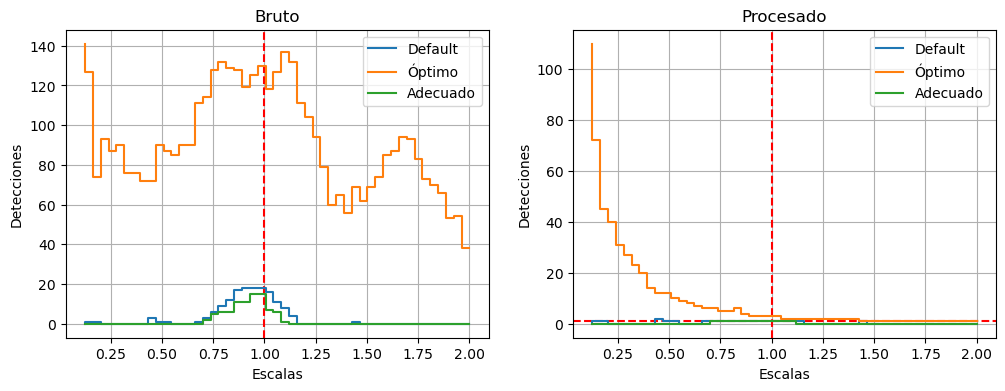

In [30]:
number_faces = 1

fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].set_title('Bruto')
ax[0].axvline(x=true_scale, ls = '--', color='red')
ax[0].step(test_scales, raw_detections[:,0], label = 'Default')
ax[0].step(test_scales, raw_detections[:,1], label = 'Óptimo')
ax[0].step(test_scales, raw_detections[:,2], label = 'Adecuado')
ax[0].grid(True)
ax[0].set_xlabel('Escalas')
ax[0].set_ylabel('Detecciones')
ax[0].legend()

ax[1].set_title('Procesado')
ax[1].axvline(x=true_scale, ls = '--', color='red')
ax[1].axhline(y=number_faces, ls = '--', color='red')
ax[1].step(test_scales, detections[:,0], label = 'Default')
ax[1].step(test_scales, detections[:,1], label = 'Óptimo')
ax[1].step(test_scales, detections[:,2], label = 'Adecuado')
ax[1].grid(True)
ax[1].set_xlabel('Escalas')
ax[1].set_ylabel('Detecciones')
ax[1].legend()
plt.savefig(directorio_experimento + r'\detecciones_vs_escalas.png')
plt.show()